#### Инициализация

In [1]:
'''Импорт библиотек'''
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
import cv2
#pip install opencv-python
import numpy as np
from lmfit.models import GaussianModel
gauss = GaussianModel()

'''Подавление предупреждений срабатывания lmfit.GaussModel.guess() -- она создаёт UFloat'''
import warnings
warnings.filterwarnings("ignore", message="Using UFloat objects with std_dev==0")

'''Частота излучения и сечение поглощения'''
frequency = 709078373.01 * 10 ** 6 # [Hz]
c = 299792458 # [m/s]
wavelength = (c/frequency) * 10 ** 2 # [cm]
crosssection = (3 * wavelength ** 2 ) / (2 * np.pi) # [cm^2]

#### Обработка

In [99]:
filename = "image_61"
directory = r"../2025-05-16_AbIm/"

'''Чтение и разбиение файла'''
img = PIL.Image.open(directory + filename + ".tif")
for i in range(2):
    try:
        img.seek(i)
        img.save(r"./proc/" + filename + '_' + str(i) + ".tif")
    except EOFError:
        break

#cv2.imread() переводит из RGB в градации серого
I_atoms = cv2.imread(r"./proc/" + filename + '_' + str(0) + ".tif", cv2.IMREAD_GRAYSCALE) # I #68
I_lbeam = cv2.imread(r"./proc/" + filename + '_' + str(1) + ".tif", cv2.IMREAD_GRAYSCALE) # I0 #72

'''Приведение к uint8 и замена нулей, чтобы не возникало ошибок при делении матриц'''
I_atoms = cv2.normalize(I_atoms, None, 1, 256, cv2.NORM_MINMAX, dtype=cv2.CV_16U)
I_lbeam = cv2.normalize(I_lbeam, None, 1, 256, cv2.NORM_MINMAX, dtype=cv2.CV_16U)

'''Определение количества пикселей по осям i и j'''
rows = len(I_lbeam) # ось i
columns = len(I_lbeam[0]) # ось j
#print("i =", strings, "\nj =", columns)

In [104]:
'''Определение пропускания T(x,y)'''
T = (I_atoms/I_lbeam).astype("float32")
#n2 = -np.log(F)/crosssection

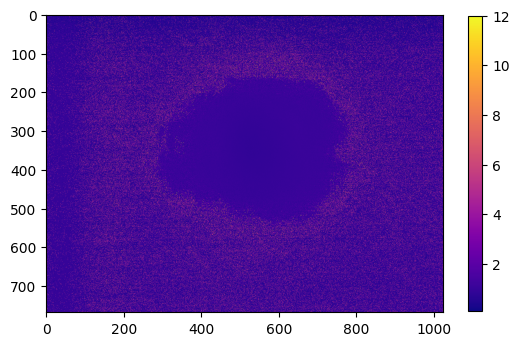

In [105]:
'''Визуализация'''
plt.imshow(T, cmap="plasma") #здесь ещё требуется калибровка по горизонтальной оси
plt.colorbar(shrink=.8)

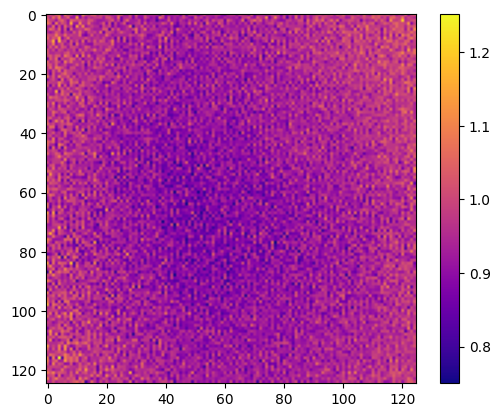

In [106]:
'''Выделение области интереса'''
(i1, j1) = (275, 475)
(i2, j2) = (400, 600)
T_cr = T[i1:i2,j1:j2]
plt.imshow(T_cr, cmap="plasma")
plt.colorbar(shrink=1)

#### Поиск центра облака

In [107]:
M = cv2.medianBlur(F, 5)
M = cv2.medianBlur(M, 5)
M = cv2.medianBlur(M, 5)
M = cv2.medianBlur(M, 5)

In [108]:
'''Нахождение точки минимума пропускания'''
C = 1.
ic = None
jc = None
for i in range(rows): #rows
    for j in range(columns): #columns
        if M[i, j] < C:
            C = M[i, j]
            ic = i
            jc = j
print("C:", T[ic, jc],"\n(", ic, ',', jc, ')')

C: 0.125 
( 0 , 305 )


In [110]:
'''Нахождение точки минимума пропускания'''
C = 1.
ic = None
jc = None
for i in range(i1, i2, 1): #rows
    for j in range(j1, j2, 1): #columns
        if T[i, j] < C:
            C = T[i, j]
            ic = i
            jc = j
print("C:", T[ic, jc],"\n(", ic, ',', jc, ')')

C: 0.75 
( 352 , 552 )


In [168]:
ic = 350
jc = 580
C = T[ic, jc]

#### Обработка центральной горизонтали

fwhm: 87.931 px
deviation: 37.341 px
peak transmission: 0.877 rel.u.


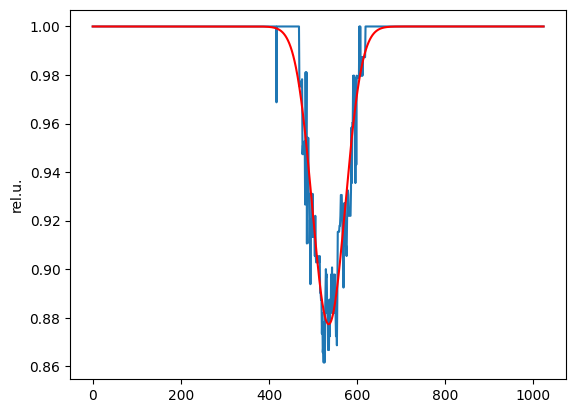

In [15]:
'''Профиль по оси j (для величины w_x)'''
data = 1-M[ic, :]
arg = np.arange(0, columns, 1)
plt.plot(arg, 1-data)

#Фитирование
model = GaussianModel()
params = gauss.guess(data, x=arg) #затравочные параметры
out = gauss.fit(data, params, x=arg, calc_covar=False)
#print(out.fit_report())

fwhm_x = out.params['fwhm'].value
w_x = out.params['sigma'].value
Peak = 1-max(out.best_fit)

print('fwhm:', '%.3f' % fwhm_x, 'px')
print('deviation:', '%.3f' % w_x, 'px')
print('peak transmission:', '%.3f' % Peak, 'rel.u.')

plt.ylabel("rel.u.")
plt.plot(arg, 1-out.best_fit, 'r-')
plt.show()

In [ ]:
'''Расчет пиковой концентрации.'''
n0 = -np.log(Tmin)/(np.sqrt(2*np.pi)*w_x*crosssection)
print('n0:', '%.2e' % n0, 'px^-1cm^-2') #необходима калибровка w_x в cm